<a href="https://colab.research.google.com/github/nmatsumoto-lgtm/study-KIKAGAKU/blob/main/%E4%B8%8D%E5%8B%95%E7%94%A3%E4%BE%A1%E6%A0%BC%E4%BA%88%E6%B8%AC%E3%82%A2%E3%83%97%E3%83%AA_Ver_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install lightgbm==4.5.0 optuna==3.6.1 joblib pandas numpy scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 49.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 24.0 MB/s eta 0:00:00


In [2]:
from __future__ import annotations
import json
from pathlib import Path
from dataclasses import dataclass


import numpy as np
import pandas as pd
import optuna
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_log_error
from joblib import dump

In [3]:
SEED = 0
np.random.seed(SEED)

In [4]:
IN = Path("data/interim/train_tabular.csv")
OUT_DIR = Path("models"); OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
# === 中央区 5エリア：駅→エリアの固定マップ ===
STATION_TO_AREA = {
    # ① 銀座・京橋
    "銀座": "銀座・京橋",
    "東銀座": "銀座・京橋",
    "銀座一丁目": "銀座・京橋",
    "京橋(東京)": "銀座・京橋",
    "宝町(東京)": "銀座・京橋",
    "新橋": "銀座・京橋",
    "汐留": "銀座・京橋",
    "東京": "銀座・京橋",  # 日本橋側に寄せたい場合は「日本橋・人形町」へ変更可

    # ② 日本橋・人形町
    "日本橋(東京)": "日本橋・人形町",
    "三越前": "日本橋・人形町",
    "新日本橋": "日本橋・人形町",
    "茅場町": "日本橋・人形町",
    "人形町": "日本橋・人形町",
    "水天宮前": "日本橋・人形町",
    "浜町": "日本橋・人形町",
    "東日本橋": "日本橋・人形町",
    "小伝馬町": "日本橋・人形町",
    "馬喰横山": "日本橋・人形町",
    "馬喰町": "日本橋・人形町",

    # ③ 月島・勝どき・晴海
    "月島": "月島・勝どき・晴海",
    "勝どき": "月島・勝どき・晴海",

    # ④ 築地・八丁堀
    "築地": "築地・八丁堀",
    "築地市場": "築地・八丁堀",
    "新富町(東京)": "築地・八丁堀",
    "八丁堀(東京)": "築地・八丁堀",
}

AREA_LIST = ["銀座・京橋", "日本橋・人形町", "月島・勝どき・晴海", "築地・八丁堀", "佃・新川・湊", "その他"]

def station_to_area(station_name: str) -> str:
    """駅名を5エリアに変換。未登録は 'その他'。"""
    if not isinstance(station_name, str) or station_name.strip() == "":
        return "その他"
    return STATION_TO_AREA.get(station_name.strip(), "その他")

In [6]:
# ============================
# 1) データ読み込み & 追加特徴量
# ============================

def _oof_target_median(df: pd.DataFrame, key: str, y: np.ndarray, n_splits: int = 5) -> np.ndarray:
    """キー列ごとの OOF 中央値エンコーディング（リーク防止）。
    戻り値は各行に対応する OOF 推定値（学習折ごとに学習外の中央値を使う）。
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        med = (
            pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
            .groupby(key)["y"].median()
        )
        oof[va_idx] = df.iloc[va_idx][key].map(med).fillna(med.median()).values
    return oof

def _oof_target_mean(df, key, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
    oof = np.zeros(len(df), dtype=float)
    for tr_idx, va_idx in kf.split(df):
        m = (pd.DataFrame({key: df.iloc[tr_idx][key].values, "y": y[tr_idx]})
             .groupby(key)["y"].mean())
        oof[va_idx] = df.iloc[va_idx][key].map(m).fillna(m.mean()).values
    return oof

def build_table_and_features() -> tuple[pd.DataFrame, list[str], list[str], list[str], list[int]]:
    df = pd.read_csv(IN)

    # ===== 対数ターゲット =====
    y = df["price_yen"].astype(float).values
    y_log = np.log1p(y)

    # ===== 5エリアを駅から自動付与（入力は駅のまま）=====
    df["area_group"] = df["station"].astype(str).apply(station_to_area)

    # ===== 追加特徴量 =====
    df["access_score"] = 1.0 / (1.0 + df["walk_min"].astype(float))
    df["sqrt_area"]    = np.sqrt(np.clip(df["area_sqm"].astype(float), 0, None))
    df["log_area"]     = np.log1p(np.clip(df["area_sqm"].astype(float), 0, None))
    df["age_sqrt"]     = np.sqrt(np.clip(df["築年数"].astype(float), 0, None))
    df["area_x_access"]= df["area_sqm"].astype(float) * df["access_score"].astype(float)

    # ===== 頻度特徴量 =====
    station_cnt = df["station"].value_counts()
    layout_cnt  = df["layout"].value_counts()
    area_cnt    = df["area_group"].value_counts()

    df["station_count"] = df["station"].map(station_cnt).fillna(0).astype(int)
    df["layout_count"]  = df["layout"].map(layout_cnt).fillna(0).astype(int)
    df["area_count"]    = df["area_group"].map(area_cnt).fillna(0).astype(int)

    # ===== OOF 目標エンコード（対数ターゲットで中央値）=====
    df["station_oof_median_log"] = _oof_target_median(df, "station",     y_log)
    df["layout_oof_median_log"]  = _oof_target_median(df, "layout",      y_log)
    df["area_oof_median_log"]    = _oof_target_median(df, "area_group",  y_log)

    # ===== OOF 目標エンコード（対数ターゲットで平均）=====  ←★ ここを追加
    df["station_oof_mean_log"] = _oof_target_mean(df, "station",    y_log)
    df["layout_oof_mean_log"]  = _oof_target_mean(df, "layout",     y_log)
    df["area_oof_mean_log"]    = _oof_target_mean(df, "area_group", y_log)


    # ===== 推論用に学習時統計を準備 =====
    station_med_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].median().to_dict()
    )
    layout_med_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].median().to_dict()
    )
    area_med_map = (
        pd.DataFrame({"area_group": df["area_group"], "y_log": y_log})
        .groupby("area_group")["y_log"].median().to_dict()
    )

    # ←★ ここから “平均” を追加
    station_mean_map = (
        pd.DataFrame({"station": df["station"], "y_log": y_log})
        .groupby("station")["y_log"].mean().to_dict()
    )
    layout_mean_map = (
        pd.DataFrame({"layout": df["layout"], "y_log": y_log})
        .groupby("layout")["y_log"].mean().to_dict()
    )
    area_mean_map = (
        pd.DataFrame({"area_group": df["area_group"], "y_log": y_log})
        .groupby("area_group")["y_log"].mean().to_dict()
    )

    global_station_med = float(np.median(list(station_med_map.values()))) if len(station_med_map) else float(np.median(y_log))
    global_layout_med  = float(np.median(list(layout_med_map.values())))  if len(layout_med_map)  else float(np.median(y_log))
    global_area_med    = float(np.median(list(area_med_map.values())))    if len(area_med_map)    else float(np.median(y_log))

    # 参考：平均の“全体値”も欲しければ
    global_station_mean = float(np.mean(list(station_mean_map.values()))) if len(station_mean_map) else float(np.mean(y_log))
    global_layout_mean  = float(np.mean(list(layout_mean_map.values())))  if len(layout_mean_map)  else float(np.mean(y_log))
    global_area_mean    = float(np.mean(list(area_mean_map.values())))    if len(area_mean_map)    else float(np.mean(y_log))

    # ===== カテゴリ列（area を先頭に追加）=====
    feat_cat = ["area_group", "station", "layout"]

    # ===== 数値列 =====
    feat_num_base = ["walk_min", "築年数", "area_sqm"]
    feat_num_extra = [
        "access_score", "sqrt_area", "log_area", "age_sqrt",
        "area_x_access",
        "station_count", "layout_count", "area_count",
        "station_oof_median_log", "layout_oof_median_log", "area_oof_median_log",
        "station_oof_mean_log", "layout_oof_mean_log", "area_oof_mean_log",
    ]
    feat_num_all = feat_num_base + feat_num_extra

    # 単調制約を「名前で」安全に指定
    mono_dict = {name: 0 for name in feat_num_all}
    mono_dict.update({
        "walk_min": -1,      # 遠いほど↓
        "築年数": -1,         # 古いほど↓
        "area_sqm": +1,      # 広いほど↑
        # ← 派生も一貫させる
        "access_score": +1,  # 駅近スコアが高いほど↑（walk_minと反対符号に注意だが整合的）
        "sqrt_area": +1,
        "log_area": +1,
        "age_sqrt": -1,
     })
    monotone_constraints = [0] * len(feat_cat) + [mono_dict[c] for c in feat_num_all]

    # # ===== 単調性制約（[cat..., num...] の順）=====
    # n_cat = len(feat_cat)
    # # walk_min↓, 築年数↓, area_sqm↑、その他は制約なし
    # mono_num = [-1, -1, +1] + [0] * (len(feat_num_all) - 3)
    # monotone_constraints = [0] * n_cat + mono_num

    # ===== エンコードして学習用テーブル =====
    oe = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    X_cat = oe.fit_transform(df[feat_cat].fillna("NA")).astype("int32")
    X_num = df[feat_num_all].astype(float).values
    X = np.hstack([X_cat, X_num])

    cat_cols = [f"cat__{c}" for c in feat_cat]
    num_cols = feat_num_all.copy()
    X_df = pd.DataFrame(X, columns=cat_cols + num_cols)
    categorical_feature = cat_cols

    meta = {
        "feat_cat": feat_cat,
        "feat_num": num_cols,
        "categorical_feature": categorical_feature,
        "monotone_constraints": monotone_constraints,
    }

    # ===== 推論用マップ（station→area を含めて保存）=====
    infer_maps = {
        "station_count_map": station_cnt.to_dict(),
        "layout_count_map":  layout_cnt.to_dict(),
        "area_count_map":    area_cnt.to_dict(),

        "station_median_log_map": station_med_map,
        "layout_median_log_map":  layout_med_map,
        "area_median_log_map":    area_med_map,

        "global_station_median_log": global_station_med,
        "global_layout_median_log":  global_layout_med,
        "global_area_median_log":    global_area_med,

        # ↓↓↓ 追加（平均）
        "station_mean_log_map": station_mean_map,
        "layout_mean_log_map":  layout_mean_map,
        "area_mean_log_map":    area_mean_map,

        "global_station_median_log": global_station_med,
        "global_layout_median_log":  global_layout_med,
        "global_area_median_log":    global_area_med,

        # （必要なら平均の全体値も）
        "global_station_mean_log": global_station_mean,
        "global_layout_mean_log":  global_layout_mean,
        "global_area_mean_log":    global_area_mean,

        "station_to_area_map": {s: station_to_area(s) for s in sorted(df["station"].astype(str).unique())},
        "area_groups": AREA_LIST,

        "feat_cat": feat_cat,
        "feat_num": num_cols,

        # 駅→エリア（推論で駅入力から自動付与）
        "station_to_area_map": {s: station_to_area(s) for s in sorted(df["station"].astype(str).unique())},
        "area_groups": AREA_LIST,

        "feat_cat": feat_cat,
        "feat_num": num_cols,
    }

    # 返り値（従来どおり）
    return X_df, y_log, categorical_feature, monotone_constraints, meta, oe, infer_maps

In [7]:
# ============================
# 2) Optuna でハイパラ探索
# ============================

def tune_with_optuna(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    n_trials: int = 80,
) -> tuple[dict, int, float]:
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)

    def objective(trial: optuna.Trial) -> float:
        params = {
            "objective": "rmse",  # 対数価格の RMSE → RMSLE 等価
            "metric": "rmse",
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 255),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 200),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 0, 10),
            "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 5.0),
            "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
            "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
            "verbosity": -1,
            "seed": SEED,
            "monotone_constraints": monotone_constraints,
        }
        rmsles = []
        best_iters = []
        for tr_idx, va_idx in kf.split(X_df):
            X_tr, X_va = X_df.iloc[tr_idx], X_df.iloc[va_idx]
            y_tr, y_va = y_log[tr_idx], y_log[va_idx]
            dtr = lgb.Dataset(X_tr, label=y_tr, categorical_feature=categorical_feature, free_raw_data=True)
            dva = lgb.Dataset(X_va, label=y_va, categorical_feature=categorical_feature, free_raw_data=True)

            model = lgb.train(
                params,
                dtr,
                valid_sets=[dva],
                num_boost_round=4000,
                callbacks=[lgb.early_stopping(200, verbose=False)],
            )
            pred_log = model.predict(X_va, num_iteration=model.best_iteration)
            # y_log の RMSE = RMSLE（expm1 に戻した価格に対する）
            rmsle = float(np.sqrt(mean_squared_log_error(np.expm1(y_va), np.expm1(pred_log))))
            rmsles.append(rmsle)
            best_iters.append(model.best_iteration)
        trial.set_user_attr("best_iters", best_iters)
        return float(np.mean(rmsles))

    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials)

    best_params = study.best_params
    # CV で選ばれた best_iteration を平均化
    best_iters_list = study.best_trial.user_attrs.get("best_iters", [1000])
    best_round = int(np.clip(np.mean(best_iters_list), 100, 4000))
    best_score = study.best_value
    return best_params, best_round, best_score

In [13]:
# ============================
# 3) 最終学習（ポイント & 分位点）
# ============================

def train_final_models(
    X_df: pd.DataFrame,
    y_log: np.ndarray,
    categorical_feature: list[str],
    monotone_constraints: list[int],
    best_params: dict,
    best_round: int,
):
    base_params = dict(best_params)
    base_params.update({
        "objective": "rmse",
        "metric": "rmse",
        "verbosity": -1,
        "seed": SEED,
        # ★ ポイントモデルでは単調性制約を使う
        "monotone_constraints": monotone_constraints,
    })

    # 生データを解放しない（categorical_feature を後で使えるように）
    dtrain = lgb.Dataset(
        X_df,
        label=y_log,
        categorical_feature=categorical_feature,
        free_raw_data=False
    )

    # ---- ポイント（対数価格）----
    model_point = lgb.train(base_params, dtrain, num_boost_round=best_round)

    # ---- smearing（log1p → 円の戻し補正）----
    pred_log_tr = model_point.predict(X_df, num_iteration=getattr(model_point, "best_iteration", None))
    resid = y_log - pred_log_tr               # eps = y_log - yhat_log
    smearing = float(np.mean(np.exp(resid)))  # E[exp(eps)]

    # ---- 分位点（q10/q90）----
    models_q = {}
    for alpha, tag in [(0.1, "q10"), (0.9, "q90")]:
        q_params = dict(best_params)
        q_params.update({
            "objective": "quantile",
            "alpha": alpha,
            "metric": "quantile",
            "verbosity": -1,
            "seed": SEED,
            # ★ ここが重要：quantile では単調性制約を外す
            # "monotone_constraints": monotone_constraints,  # ←入れない
        })
        models_q[tag] = lgb.train(q_params, dtrain, num_boost_round=best_round)

    return model_point, models_q, smearing


In [14]:
# ===== 入力CSV→中間CSVの自動生成（なければ作る） =====
from pathlib import Path
import pandas as pd, numpy as np, re
from datetime import datetime

RAW_CSV = Path("/content/Tokyo_Chuo Ward_20242_20251.csv")
IN = Path("data/interim/train_tabular.csv")
ST_OUT = Path("data/interim/stations.csv")
IN.parent.mkdir(parents=True, exist_ok=True)

def _read_chuo_and_save(raw_csv: Path, out_csv: Path, stations_csv: Path):
    # エンコーディングを順に試す（Excel想定）
    last_err = None
    for enc in ("cp932", "utf-8-sig", "utf-8", "utf-16", "utf-16le", "utf-16be"):
        try:
            raw = pd.read_csv(raw_csv, encoding=enc)
            break
        except Exception as e:
            last_err = e
            raw = None
    if raw is None:
        raise last_err

    def _to_year(x):
        if pd.isna(x): return np.nan
        m = re.search(r"(\d{4})年", str(x))
        return int(m.group(1)) if m else np.nan

    df = raw[["最寄駅：名称","最寄駅：距離（分）","間取り","面積（㎡）","建築年","取引価格（総額）"]].copy()

    build_year = df["建築年"].apply(_to_year)
    current_year = datetime.now().year
    df["築年数"] = (current_year - build_year).clip(lower=0)

    for col in ["最寄駅：距離（分）","面積（㎡）","築年数"]:
        df[col] = pd.to_numeric(df[col], errors="coerce").fillna(df[col].median())

    def _normalize_layout(s):
        if not isinstance(s,str): return "その他"
        s = s.upper().replace("Ｌ","L").replace("Ｄ","D").replace("Ｋ","K").replace("Ｒ","R")
        m = re.search(r"(\d+)(LDK|DK|K|R)", s)
        return m.group(0) if m else "その他"

    train = df.rename(columns={
        "最寄駅：名称":"station",
        "最寄駅：距離（分）":"walk_min",
        "面積（㎡）":"area_sqm",
        "取引価格（総額）":"price_yen",
    })[["station","walk_min","築年数","area_sqm","price_yen"]].copy()
    train["layout"] = df["間取り"].astype(str).apply(_normalize_layout)

    # 保存（StreamlitもこのCSVを読む）
    train.to_csv(out_csv, index=False)

    # 駅リスト保存（utf-8-sig）
    s = (raw["最寄駅：名称"].astype(str)
           .replace({"nan":np.nan,"None":np.nan,"":np.nan})
           .dropna()
           .str.normalize("NFKC")
           .str.replace("（","(",regex=False).str.replace("）",")",regex=False)
           .str.replace("　"," ",regex=False).str.strip()
           .str.replace(r"\s+"," ",regex=True))
    pd.Series(sorted(s.unique())).to_csv(stations_csv, index=False, header=False, encoding="utf-8-sig")

# まだ中間CSVがない場合は作る
if not IN.exists():
    if not RAW_CSV.exists():
        raise FileNotFoundError(f"Raw CSV が見つかりません: {RAW_CSV.resolve()}")
    _read_chuo_and_save(RAW_CSV, IN, ST_OUT)

In [16]:
# ============================
# 4) 実行
# ============================

if __name__ == "__main__":
    assert IN.exists(), f"Not found: {IN}"

    # ★ infer_maps まで受け取る（関数が infer_maps を返す実装になっている前提）
    X_df, y_log, cat_cols, mono_cons, meta, oe, infer_maps = build_table_and_features()

    print(f"Train rows: {len(X_df):,}, cols: {X_df.shape[1]} (cats={len(cat_cols)})")

    best_params, best_round, best_score = tune_with_optuna(
        X_df, y_log, cat_cols, mono_cons, n_trials=80
    )
    print("[OPTUNA] best RMSLE:", round(best_score, 4))
    print("[OPTUNA] best params:")
    for k, v in best_params.items():
        print(f"  {k}: {v}")
    print("[OPTUNA] best_round:", best_round)

    model_point, models_q, smearing = train_final_models(
        X_df, y_log, cat_cols, mono_cons, best_params, best_round
    )

    # ===== 保存 =====
    # 予測時に使うメタ情報（列順や制約）とエンコーダを一緒に保存しておく
    dump({
        "model": model_point,
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "smearing": smearing,
    }, OUT_DIR / "lgbm_optuna_point.pkl")

    dump({
        "model": models_q["q10"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.1,
        "smearing": smearing,
    }, OUT_DIR / "lgbm_optuna_q10.pkl")

    dump({
        "model": models_q["q90"],
        "encoder": oe,
        "cat_cols": meta["feat_cat"],
        "num_cols": meta["feat_num"],
        "categorical_feature": meta["categorical_feature"],
        "monotone_constraints": meta["monotone_constraints"],
        "target": "log_price_yen",
        "alpha": 0.9,
        "smearing": smearing,
    }, OUT_DIR / "lgbm_optuna_q90.pkl")

    with open(OUT_DIR / "feature_config.json", "w", encoding="utf-8") as f:
        json.dump({
            "feat_cat": meta["feat_cat"],
            "feat_num": meta["feat_num"],
            "categorical_feature": meta["categorical_feature"],
            "monotone_constraints": meta["monotone_constraints"],
            "notes": "y is log1p(price_yen). During inference, apply expm1 to predictions.",
        }, f, ensure_ascii=False, indent=2)

    # ★ 推論用マップも保存（カッコを閉じるのを忘れない）
    with open(OUT_DIR / "infer_maps.json", "w", encoding="utf-8") as f:
        json.dump(infer_maps, f, ensure_ascii=False, indent=2)

    print("Saved models →", OUT_DIR)


[I 2025-09-06 03:24:12,179] A new study created in memory with name: no-name-15897d75-0661-4190-aa1c-31b2f80bfb81


Train rows: 1,784, cols: 20 (cats=3)


[I 2025-09-06 03:24:12,442] Trial 0 finished with value: 0.26773927065274206 and parameters: {'learning_rate': 0.03510251631172873, 'num_leaves': 74, 'min_data_in_leaf': 187, 'feature_fraction': 0.641773282629177, 'bagging_fraction': 0.6195502424853235, 'bagging_freq': 9, 'min_gain_to_split': 2.1971280489198532, 'lambda_l1': 0.0650990266225712, 'lambda_l2': 8.6773585509479e-05}. Best is trial 0 with value: 0.26773927065274206.
[I 2025-09-06 03:24:12,974] Trial 1 finished with value: 0.22412771065737175 and parameters: {'learning_rate': 0.014157778154215636, 'num_leaves': 222, 'min_data_in_leaf': 107, 'feature_fraction': 0.7145761214281922, 'bagging_fraction': 0.7164954774072607, 'bagging_freq': 3, 'min_gain_to_split': 1.9519260146980595, 'lambda_l1': 0.0053641499733811104, 'lambda_l2': 1.5929961460617827}. Best is trial 1 with value: 0.22412771065737175.
[I 2025-09-06 03:24:13,764] Trial 2 finished with value: 0.1996943654061749 and parameters: {'learning_rate': 0.01043350616875534, 'n

[OPTUNA] best RMSLE: 0.1784
[OPTUNA] best params:
  learning_rate: 0.010898362305864431
  num_leaves: 117
  min_data_in_leaf: 13
  feature_fraction: 0.9772369001314373
  bagging_fraction: 0.8773012033625296
  bagging_freq: 0
  min_gain_to_split: 0.004102743410337173
  lambda_l1: 3.3514666887157894e-05
  lambda_l2: 1.6015308020766786e-05
[OPTUNA] best_round: 579
Saved models → models


                   feature    importance
5                 area_sqm  31828.613125
4                      築年数   4837.167678
10           area_x_access   1114.813972
15   layout_oof_median_log    944.889993
18     layout_oof_mean_log    387.955645
11           station_count    208.360259
14  station_oof_median_log    205.291195
2              cat__layout    173.522983
17    station_oof_mean_log    164.727729
12            layout_count    126.948611
1             cat__station    122.277434
3                 walk_min     99.905119
19       area_oof_mean_log     83.939199
16     area_oof_median_log     65.310377
0          cat__area_group     42.787109
13              area_count     16.923666
6             access_score      1.777886
8                 log_area      0.000000
7                sqrt_area      0.000000
9                 age_sqrt      0.000000


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 31689 (\N{CJK UNIFIED IDEOGRAPH-7BC9}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24180 (\N{CJK UNIFIED IDEOGRAPH-5E74}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


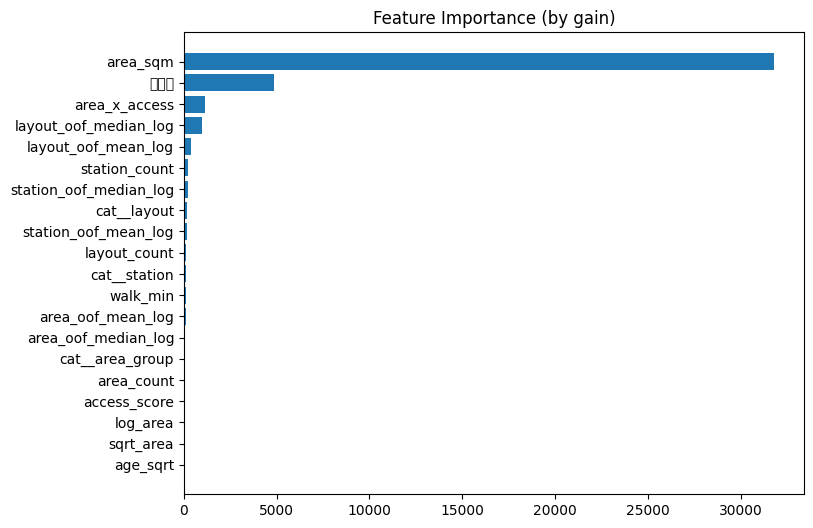

In [17]:
import matplotlib.pyplot as plt

# 重要度を取得
importance = model_point.feature_importance(importance_type="gain")
feature_names = model_point.feature_name()

# DataFrame化
import pandas as pd
fi = pd.DataFrame({
    "feature": feature_names,
    "importance": importance
}).sort_values("importance", ascending=False)

print(fi)

# 棒グラフで可視化
plt.figure(figsize=(8, 6))
plt.barh(fi["feature"], fi["importance"])
plt.gca().invert_yaxis()
plt.title("Feature Importance (by gain)")
plt.show()